### Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import libraries

In [ ]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import sys
import sklearn as sk
import pandas as pd
import sklearn.feature_extraction.text as sk_text
import seaborn as sns
import cv2
import glob
from IPython.display import Image
from collections.abc import Sequence
from sklearn import preprocessing, metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
import shutil
import os
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten
import io
from sklearn.model_selection import train_test_split

print("Python {}".format(sys.version))
print('Pandas {}'.format(pd.__version__))
print('Numpy {}'.format(np.__version__))
print('Scikit-Learn {}'.format(sk.__version__))
print()
print("Tensor Flow Version: {}".format(tf.__version__))

Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Pandas 1.5.3
Numpy 1.23.5
Scikit-Learn 1.2.2

Tensor Flow Version: 2.14.0


### Helper Functions

In [ ]:
#helpful functions
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low

### Load Textual Dataset


In [ ]:
#data location
filename_read = os.path.join("drive/MyDrive/CSC180 Project 3 Dataset/Houses Dataset/HousesInfo.txt")

#column names
cols=["Bedrooms","Bathrooms","area","zipcode","price"]

#read data into dataframe
houseInfo = pd.read_csv(filename_read , sep=" ", header=None , names=cols)

In [ ]:
#Dataset
houseInfo.head()

,Bedrooms,Bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


### Load Image Dataset

In [ ]:
## Bathroom.jpg
new_images=[]
for number in range(1, 536):
    for path in glob.glob("drive/MyDrive/CSC180 Project 3 Dataset/Houses Dataset/" + str(number) + "_bathroom.jpg"):
        if os.path.isfile(path):
            new_images.append(path)

In [ ]:
#add bathroom to collective image
img= pd.DataFrame(new_images,columns = ['bathroom_img'])

In [ ]:
## bedroom images
bedroom_images = []
for number in range(1, 536):
    for path in glob.glob("drive/MyDrive/CSC180 Project 3 Dataset/Houses Dataset/" + str(number) + "_bedroom.jpg"):
        if os.path.isfile(path):
            bedroom_images.append(path)

In [ ]:
#add bedroom to collective image
img['bedroom_img']=bedroom_images

In [ ]:
#frontal images
frontal_images = []
for number in range(1, 536):
    for path in glob.glob("drive/MyDrive/CSC180 Project 3 Dataset/Houses Dataset/" + str(number) + "_frontal.jpg"):
        if os.path.isfile(path):
            frontal_images.append(path)

In [ ]:
#add frontal to collective image
img['frontal_img']=frontal_images

In [ ]:
#kitchen images
kitchen_images = []
for number in range(1, 536):
    for path in glob.glob("drive/MyDrive/CSC180 Project 3 Dataset/Houses Dataset/" + str(number) + "_kitchen.jpg"):
        if os.path.isfile(path):
            kitchen_images.append(path)

In [ ]:
#add kitchen to collective image
img['kitchen_img']=kitchen_images

In [ ]:
#check to make sure loaded in properly
img.head()

,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...
1,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...
2,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...
3,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...
4,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...,drive/MyDrive/CSC180 Project 3 Dataset/Houses ...


In [ ]:
#check shape is correct
img.shape

(535, 4)

### Transform Image Dataset

In [ ]:
#concatenate house images to one (takes a while, about 10-30min)
images_output=[]
for row_index,row in img.iterrows():
            inputImages=[]
            outputImage = np.zeros((128, 128, 3), dtype="uint8")
            image_temp1 = cv2.imread(row.bathroom_img)
            image1 = cv2.resize(image_temp1, (64 , 64))

            image_temp2 = cv2.imread(row.bedroom_img)
            image2 = cv2.resize(image_temp2, (64 , 64))

            image_temp3 = cv2.imread(row.frontal_img)
            image3 = cv2.resize(image_temp3, (64 , 64))

            image_temp4 = cv2.imread(row.kitchen_img)
            image4 = cv2.resize(image_temp4, (64 , 64))

            inputImages.append(image1)
            inputImages.append(image2)
            inputImages.append(image3)
            inputImages.append(image4)

            outputImage[0:64, 0:64] = inputImages[0]
            outputImage[0:64, 64:128] = inputImages[1]
            outputImage[64:128, 64:128] = inputImages[2]
            outputImage[64:128, 0:64] = inputImages[3]


            images_output.append(outputImage)

In [ ]:
#create numpy array of images
img_arr=np.asarray(images_output)
img_arr.shape

(535, 128, 128, 3)

## Data Cleaning

### Remove Outliers

In [ ]:
#use copy so don't have to rerun time-hungry sections
img_arr_copy = img_arr

In [ ]:
#gather index list of houses with price less than 100k or more than 800k
list_to_remove = []
for i, r in houseInfo.iterrows():
  if (houseInfo.iloc[i]['price'] < 100000):
    list_to_remove.append(i)
  if (houseInfo.iloc[i]['price'] > 800000):
    list_to_remove.append(i)

#reverse list so indices being removed won't affect lower indices
list_to_remove.reverse()

In [ ]:
#remove outlier houses from both datasets
for item in list_to_remove:
  houseInfo.drop([item], inplace=True)

for item in list_to_remove:
  img_arr_copy = np.delete(img_arr_copy, item, axis=0)

### Normalize input features

In [ ]:
#normalize non-categorical features features
from scipy.stats import zscore

houseInfo_x = houseInfo.drop('price', axis=1)
houseInfo_y = houseInfo['price']

for col in houseInfo_x.columns:
  if (col != 'zipcode'):
    houseInfo_x[col] = zscore(houseInfo_x[col])

In [ ]:
#normalize categorical feature(s)
#the only categorical feature is zipcode

encode_text_dummy(houseInfo_x, 'zipcode')

### Split data into x and y

In [ ]:
#split textual data into x and y
x = houseInfo_x

#index messed up from removing rows
x = x.reset_index()

#new index column useless
x = x.drop('index', axis=1)

#numpy array for TensorFlow
x = x.to_numpy()

#same thing to y
y = houseInfo_y
y = y.reset_index()
y = y.drop('index', axis=1)
#y = y.to_numpy()

### Split into train and test data

In [ ]:
#split into x_train, x_test, y_train, and y_test

#use same random_state so the random split is reproducable
rand_state = 21
t_size = 0.20

#split both textual and image data
x_train, x_test, x_train_img, x_test_img, y_train, y_test = train_test_split(x, img_arr_copy, y, test_size=t_size, random_state=rand_state)

In [ ]:
x_train.shape

(300, 41)

In [ ]:
x_test.shape

(76, 41)

In [ ]:
y_train.shape

(300, 1)

In [ ]:
y_test.shape

(76, 1)

In [ ]:
x_train_img.shape

(300, 128, 128, 3)

In [ ]:
x_test_img.shape

(76, 128, 128, 3)

## Designing Model

### Creating Dense Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

from tensorflow.keras.utils import plot_model

act = 'relu'

visible1 = Input(shape=(x_train.shape[1],))

hidden1_1 = Dense(20, activation=act)(visible1)
output1 = Dense(1, activation=act)(hidden1_1)


In [ ]:
#create dense model as own model
from tensorflow.keras.optimizers import Adam, SGD

monitor = EarlyStopping(monitor='loss', min_delta=1e3, patience=5, verbose=2, mode='auto')

model = Model(inputs=visible1, outputs=output1)
model.compile(loss='mean_squared_error', optimizer=Adam(.1))
model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), callbacks=[monitor], verbose=2, epochs=600)

Epoch 1/600
10/10 - 1s - loss: 239835840512.0000 - val_loss: 257889075200.0000 - 1s/epoch - 125ms/step
Epoch 2/600
10/10 - 0s - loss: 239782428672.0000 - val_loss: 257778384896.0000 - 69ms/epoch - 7ms/step
Epoch 3/600
10/10 - 0s - loss: 239647522816.0000 - val_loss: 257557692416.0000 - 77ms/epoch - 8ms/step
Epoch 4/600
10/10 - 0s - loss: 239399239680.0000 - val_loss: 257191362560.0000 - 82ms/epoch - 8ms/step
Epoch 5/600
10/10 - 0s - loss: 239002435584.0000 - val_loss: 256650952704.0000 - 63ms/epoch - 6ms/step
Epoch 6/600
10/10 - 0s - loss: 238432124928.0000 - val_loss: 255921586176.0000 - 54ms/epoch - 5ms/step
Epoch 7/600
10/10 - 0s - loss: 237678575616.0000 - val_loss: 254994481152.0000 - 64ms/epoch - 6ms/step
Epoch 8/600
10/10 - 0s - loss: 236734152704.0000 - val_loss: 253852958720.0000 - 61ms/epoch - 6ms/step
Epoch 9/600
10/10 - 0s - loss: 235608375296.0000 - val_loss: 252512272384.0000 - 49ms/epoch - 5ms/step
Epoch 10/600
10/10 - 0s - loss: 234261512192.0000 - val_loss: 25098312089

In [ ]:
pred = model.predict(x_test)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("RMSE: {}".format(score))

3/3 [==============================] - 0s 3ms/step
RMSE: 97888.10874524881


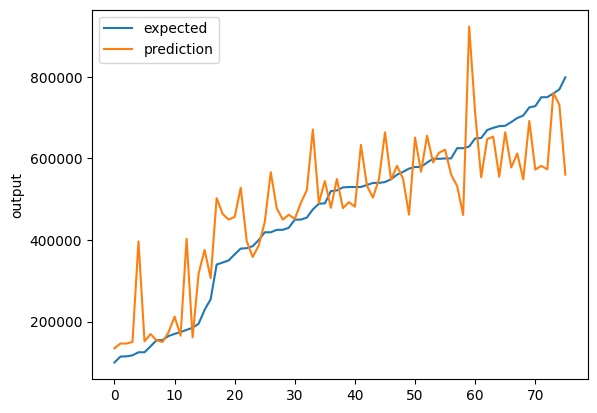

In [ ]:
#produce lift chart for test data
%matplotlib inline
chart_regression(pred.flatten(),y_test.values, sort= True)

### Creating Convolution Neural Network

In [ ]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

act = 'relu'
input_img_arr = img_arr_copy

visible2 = Input(shape=(128,128,3))

conv2_1 = Conv2D(64, kernel_size=4, activation=act)(visible2)
pool2_1 = MaxPooling2D(pool_size=(2, 2))(conv2_1)
conv2_2 = Conv2D(32, kernel_size=4, activation=act)(pool2_1)
pool2_2 = MaxPooling2D(pool_size=(2, 2))(conv2_2)
conv2_3 = Conv2D(16, kernel_size=4, activation=act)(pool2_2)
pool2_3 = MaxPooling2D(pool_size=(2, 2))(conv2_3)
flat = Flatten()(pool2_3)
output2 = Dense(1, activation=act)(flat)

In [ ]:
#create cnn model as own model for testing
from tensorflow.keras.optimizers import Adam, SGD

monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=3, verbose=2, mode='auto')

model = Model(inputs=visible2, outputs=output2)
model.compile(loss='mean_squared_error', optimizer=Adam(.1))
model.fit(x=x_train_img, y=y_train, validation_data=(x_test_img, y_test), callbacks=[monitor], verbose=2, epochs=500)

Epoch 1/500
10/10 - 16s - loss: 237487280619520.0000 - val_loss: 257925005312.0000 - 16s/epoch - 2s/step
Epoch 2/500
10/10 - 24s - loss: 239844360192.0000 - val_loss: 257925005312.0000 - 24s/epoch - 2s/step
Epoch 3/500
10/10 - 15s - loss: 239844360192.0000 - val_loss: 257925005312.0000 - 15s/epoch - 1s/step
Epoch 4/500
10/10 - 15s - loss: 239844360192.0000 - val_loss: 257925005312.0000 - 15s/epoch - 1s/step
Epoch 5/500
10/10 - 15s - loss: 239844392960.0000 - val_loss: 257925005312.0000 - 15s/epoch - 1s/step
Epoch 5: early stopping


In [ ]:
pred = model.predict(x_test_img)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("RMSE: {}".format(score))

3/3 [==============================] - 1s 300ms/step
RMSE: 507863.14570040477


### Concatenating Neural Networks

In [ ]:
from tensorflow.keras.layers import concatenate

act = 'relu'
act2 = 'linear'

merge = concatenate([output1, flat], axis=1)

# interpretation model
hidden3_1 = Dense(10, activation=act)(merge)
hidden3_2 = Dense(10, activation=act)(hidden3_1)
final_output = Dense(1, activation=act2)(hidden3_2)


### Creating Model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 125, 125, 64)         3136      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 62, 62, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 59, 59, 32)           32800     ['max_pooling2d[0][0]'] 

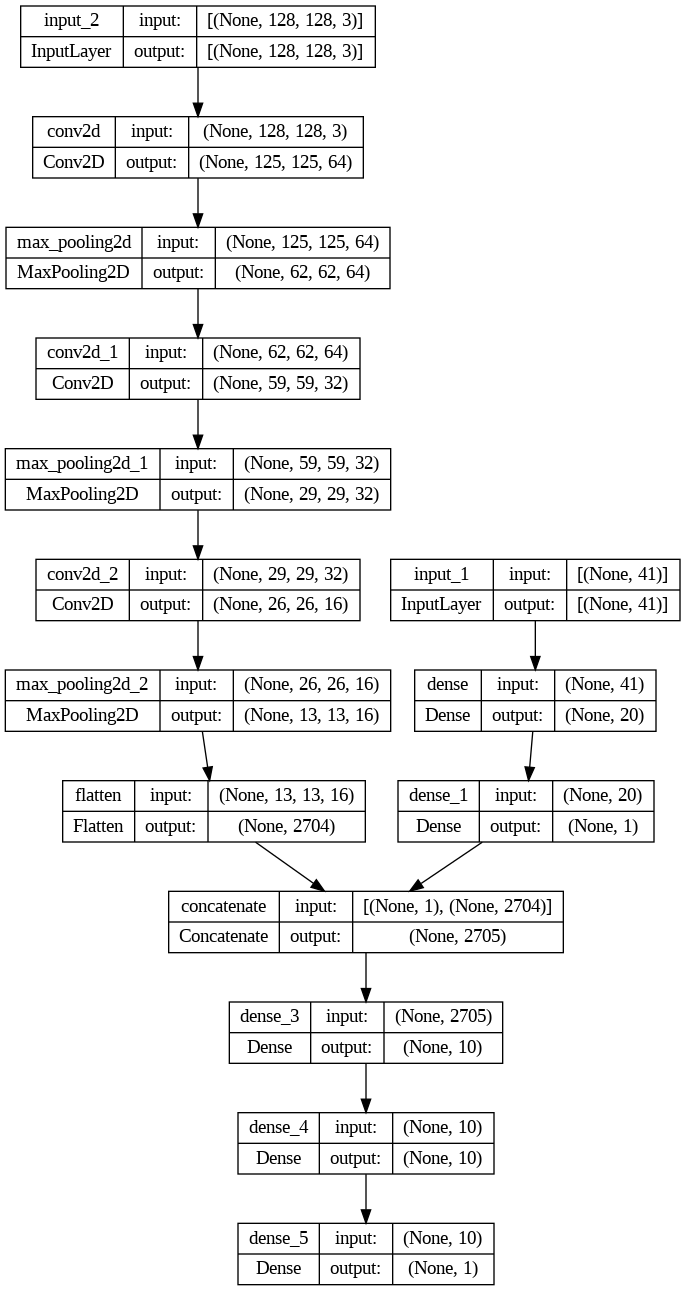

In [ ]:
model = Model(inputs=[visible1, visible2], outputs=final_output)

#show design
print(model.summary())
plot_model(model, show_shapes=True)

### Training Model

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD

monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=3, verbose=2, mode='auto')

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=.1))

model.fit(x=[x_train, x_train_img], y=y_train, validation_data=([x_test, x_test_img], y_test), callbacks=[monitor], verbose=2, epochs=200)

Epoch 1/200
10/10 - 16s - loss: 18257404755968.0000 - val_loss: 164724064256.0000 - 16s/epoch - 2s/step
Epoch 2/200
10/10 - 15s - loss: 65997492224.0000 - val_loss: 76303605760.0000 - 15s/epoch - 1s/step
Epoch 3/200
10/10 - 15s - loss: 31068178432.0000 - val_loss: 32342843392.0000 - 15s/epoch - 1s/step
Epoch 4/200
10/10 - 15s - loss: 17171992576.0000 - val_loss: 20299614208.0000 - 15s/epoch - 1s/step
Epoch 5/200
10/10 - 15s - loss: 12037647360.0000 - val_loss: 11019192320.0000 - 15s/epoch - 2s/step
Epoch 6/200
10/10 - 15s - loss: 9248573440.0000 - val_loss: 12030765056.0000 - 15s/epoch - 1s/step
Epoch 7/200
10/10 - 15s - loss: 9465946112.0000 - val_loss: 9321466880.0000 - 15s/epoch - 1s/step
Epoch 8/200
10/10 - 15s - loss: 9603438592.0000 - val_loss: 9974898688.0000 - 15s/epoch - 1s/step
Epoch 9/200
10/10 - 15s - loss: 9384302592.0000 - val_loss: 9707479040.0000 - 15s/epoch - 1s/step
Epoch 9: early stopping


### Predicting With Model

In [ ]:
#Predict using model

pred = model.predict([x_test,x_test_img])

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("RMSE: {}".format(score))

3/3 [==============================] - 1s 182ms/step
RMSE: 98526.5403817075


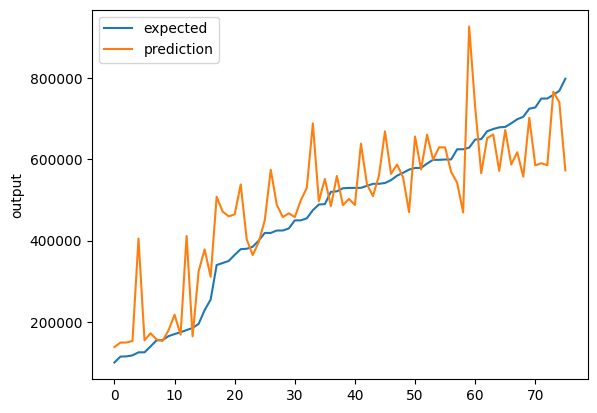

In [ ]:
#produce lift chart for test data
%matplotlib inline
chart_regression(pred.flatten(),y_test.values, sort= True)